In [64]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.optimize
from scipy.optimize import minimize
#from scipy.ndimage import gaussian_filter1d
import sys

In [65]:
date = '20220601'
dataNo = 2
scanNo = 12

In [66]:
path = r"./"+date
path_img = path + r"/data" + str('%03d' % dataNo) + "/raw"
path_scan = path + r"/scandir/Scan" + str('%03d' % scanNo) + '.txt'
path_param = path + r"/scandir/Parameters" + str('%03d' % scanNo) + '.txt'
scan_data = pd.read_csv(path_scan, delimiter='\t')

In [67]:
param_name = 'T0008: TOF time (msec.)'
fit_result_name_list = ['Center position (y) @ ROI1 (px)', 'Center position (x) @ ROI1 (px)']
scan_param = scan_data[param_name]
fit_result = scan_data[fit_result_name_list]
unique_param = scan_param.unique()
sample1 = unique_param[1]
sample2 = unique_param[3]
sample3 = unique_param[5]
unit = '[ms]'

In [68]:
share = Path(path_img)
if share.exists():
    trans_files = list(Path(path_img).glob('seq*_trans.tiff'))
    flat_files = list(Path(path_img).glob('seq*_flat.tiff'))
    update_files = list(Path(path_img).glob('seq*_update.tiff'))
else:
    print("No image")

In [69]:
x_center_list = []
y_center_list = []
x_center_err_list = []
y_center_err_list = []
for i in range(len(unique_param)):
    x_center_temp = []
    y_center_temp = []
    for j in range(len(trans_files)):
        if scan_param[j] == unique_param[i]:
            y_center_temp.append(fit_result[fit_result_name_list[0]][j])
            x_center_temp.append(fit_result[fit_result_name_list[1]][j])
    y_center_list.append(np.mean(y_center_temp))
    y_center_err_list.append(np.std(y_center_temp))
    x_center_list.append(np.mean(x_center_temp))
    x_center_err_list.append(np.std(x_center_temp))

fitParameter_0=-0.3176260319097511(0.0025446579431736595)
fitParameter_1=137.72100208057955(0.05531947581811752)


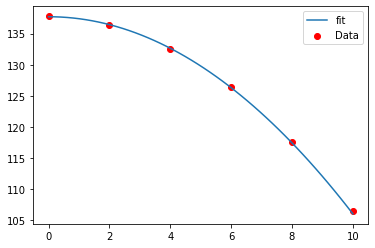

In [79]:
x_list = unique_param
nx = y_center_list


def quadratic_fucntion(x,*fit_param):
    return fit_param[0]*x**2+fit_param[1]

def fit_result(fit_func, x_data_list, y_data_list, initial_param_list, yerr=None):
    if (yerr is None):
        param, cov = scipy.optimize.curve_fit(fit_func, x_data_list, y_data_list, p0 = initial_param_list)
    else:
        param, cov = scipy.optimize.curve_fit(fit_func, x_data_list, y_data_list, p0 = initial_param_list, sigma=yerr)
    perr = np.sqrt(np.diag(cov))
    x_fit_list = np.linspace(np.min(x_data_list),np.max(x_data_list))
    y_fit_list = []
    for num in x_fit_list:
        y_fit_list.append(fit_func(num, *param))
    return param, perr, x_fit_list, y_fit_list

para_ini =[-1, np.mean(nx)]
fitResultsOfSampleImage_list = fit_result(quadratic_fucntion, x_list, nx, para_ini, y_center_err_list)

for i in range(len(para_ini)):
    print("fitParameter_"+str(i)+"="+str(fitResultsOfSampleImage_list[0][i])+"("+str(fitResultsOfSampleImage_list[1][i])+")")

plt.scatter(x_list,nx, label='Data',c="r")
plt.plot(fitResultsOfSampleImage_list[2],fitResultsOfSampleImage_list[3],label="fit")
plt.legend()

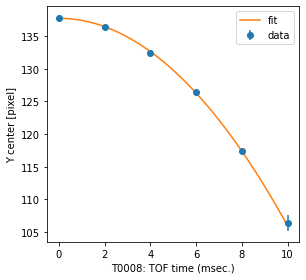

In [80]:
fig =plt.figure(figsize=[8,4])
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel(param_name)
ax1.set_ylabel('Y center [pixel]')
ax1.errorbar(unique_param,y_center_list, y_center_err_list,fmt='o',label ='data')
ax1.plot(fitResultsOfSampleImage_list[2],fitResultsOfSampleImage_list[3],label="fit")
ax1.legend()
# ax1.set_ylim(20, 100)

plt.tight_layout()
plt.show()

In [87]:
coeff = np.abs(fitResultsOfSampleImage_list[0][0])
CCD_pixel_size = 3.45 #[um]
binning = 4
gravity = 9.8065 #[m/s^2]

magnification =coeff*CCD_pixel_size*binning /(1/2*gravity)
print("Magnification = %.03f"%(magnification))
print("X center with TOF 0 = %.01f (%.01f) [px]"%(x_center_list[0], x_center_err_list[0]))
print("Y center with TOF 0 = %.01f (%.01f) [px]"%(y_center_list[0], y_center_err_list[0]))

Magnification = 0.894
X center with TOF 0 = 167.8 (0.1) [px]
Y center with TOF 0 = 137.8 (0.1) [px]
